In [ ]:
pip install qiskit

In [ ]:
pip install qiskit-aer-gpu-cu11

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator, partial_trace, entropy

from spin import *
from trotter import *
import time

In [2]:
simulator_gpu = AerSimulator(method='statevector', device='CPU')
print(simulator_gpu.available_devices())
print(simulator_gpu.available_methods())

('CPU', 'GPU')
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop', 'tensor_network')


In [ ]:
pip install cupy-cuda12x

  Using cached cupy_cuda12x-13.6.0-cp312-cp312-manylinux2014_x86_64.whl.metadata (2.4 kB)
Using cached cupy_cuda12x-13.6.0-cp312-cp312-manylinux2014_x86_64.whl (112.9 MB)


In [8]:
import cupy as cp

print(cp.__version__)

13.3.0


In [4]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
import numpy as np

n = 8
QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045, Jx=1, pbc=False)

H = QIMF.ham_xyz
print(H)

init = Statevector.from_label("10101010")
t, dt = 10.0, 0.1
r = int(round(t / dt))

[SparsePauliOp(['IIIIIIXX', 'IIIIIXXI', 'IIIIXXII', 'IIIXXIII', 'IIXXIIII', 'IXXIIIII', 'XXIIIIII', 'IIIIIIIX', 'IIIIIIXI', 'IIIIIXII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j,
 1.   +0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j,
 0.809+0.j, 0.809+0.j, 0.809+0.j]), SparsePauliOp(['IIIIIIIY', 'IIIIIIYI', 'IIIIIYII', 'IIIIYIII', 'IIIYIIII', 'IIYIIIII', 'IYIIIIII', 'YIIIIIII'],
              coeffs=[0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j,
 0.9045+0.j, 0.9045+0.j])]


In [5]:
trotter = PauliEvolutionGate(H, time=dt, synthesis=LieTrotter())
qc = QuantumCircuit(n)
start_time = time.time()
for s in range(1, r+1):
    qc.append(trotter, range(n))
    qc.save_statevector(label=f"sv_{s}")

res = simulator_gpu.run(transpile(qc, simulator_gpu), initial_statevector=init.data).result()
data = res.data(0)
states = [data[f"sv_{s}"] for s in range(1, r+1)]

entropy_list = []
for s in range(1, r):
    print(s)
    rdm1 = partial_trace(DensityMatrix(states[s-1]), [0])
    rdm2 = partial_trace(DensityMatrix(states[s-1]), [0, 1])
    rdm3 = partial_trace(DensityMatrix(states[s-1]), [0, 1, 2])
    rdm4 = partial_trace(DensityMatrix(states[s-1]), [0, 1, 2, 3])
    temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    print(temp_entropy)
    entropy_list.append(temp_entropy)
total_time = time.time() - start_time
print("total time", total_time)

1
[np.float64(0.0805723709370568), np.float64(0.08057237093705648), np.float64(0.08057237093705506), np.float64(0.08057237093705535)]
2
[np.float64(0.23377670064086267), np.float64(0.23383935710838008), np.float64(0.2338393571083766), np.float64(0.23383935710837517)]
3
[np.float64(0.39370267866919206), np.float64(0.39462667264379364), np.float64(0.39462651192692305), np.float64(0.3946265119269246)]
4
[np.float64(0.5188099182604173), np.float64(0.5239537838697601), np.float64(0.523948544305402), np.float64(0.5239485505633965)]
5
[np.float64(0.5864854127708491), np.float64(0.605067324181346), np.float64(0.6050073337486427), np.float64(0.6050075265115832)]
6
[np.float64(0.5946508224848867), np.float64(0.6460497092071364), np.float64(0.6456737859767028), np.float64(0.6456759866214454)]
7
[np.float64(0.5632816348454056), np.float64(0.6773149467518347), np.float64(0.6758744764787538), np.float64(0.6758871182549597)]
8
[np.float64(0.5310762236359285), np.float64(0.734385923344632), np.float64

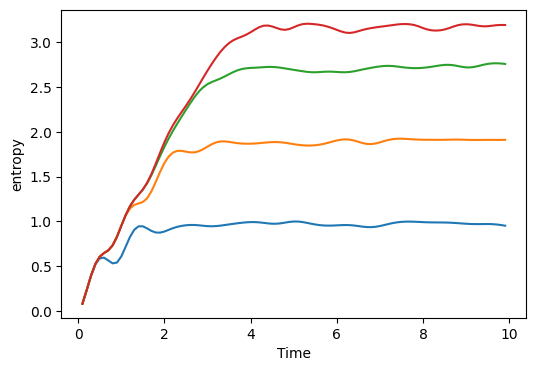

In [6]:
import matplotlib.pyplot as plt
import numpy as np

dt = 0.1
steps = len(entropy_list)
times = np.arange(1, steps+1) * dt

plt.figure(figsize=(6,4))
plt.plot(times, entropy_list)
plt.xlabel("Time")
plt.ylabel("entropy")
plt.show()